In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import sklearn
from src.utils.plot_utils import *
from src.utils.train_utils import *
from src.utils.data_utils import *
from src.utils.general_utils import *

from src.data.some_dataloader import RedditDataset

dataset = RedditDataset()
df = dataset.data
#title = RedditDataset("data/soc-redditHyperlinks-title.tsv").data
#body = RedditDataset("data/soc-redditHyperlinks-body.tsv").data

#### Sentiment Ratio

LINK_SENTIMENT year_month   -1     1  ratio_per_month
0                 2013-12    2    12         6.000000
1                 2014-01  662  8218        12.413897
2                 2014-02  660  8202        12.427273
3                 2014-03  924  9842        10.651515
4                 2014-04  774  9206        11.894057


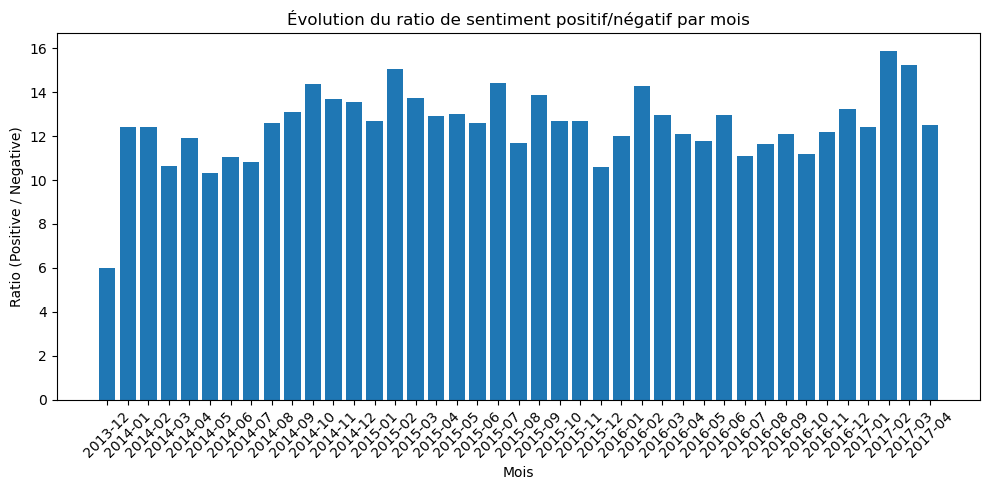

In [31]:
title = RedditDataset("data/soc-redditHyperlinks-title.tsv").data
body = RedditDataset("data/soc-redditHyperlinks-body.tsv").data
## ratio positive / negative
title['year_month'] = title['TIMESTAMP'].dt.to_period('M')
body['year_month'] = body['TIMESTAMP'].dt.to_period('M')


monthly_counts = body.groupby(['year_month', 'LINK_SENTIMENT']).size().unstack(fill_value=0)
monthly_counts['ratio_per_month'] = monthly_counts[1] / monthly_counts[-1]
ratio = monthly_counts.reset_index()

print(ratio.head())

plt.figure(figsize=(10,5))
plt.bar(ratio['year_month'].astype(str),ratio['ratio_per_month'])
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Ratio (Positive / Negative)')
plt.title('Évolution du ratio de sentiment positif/négatif par mois')
plt.tight_layout()
plt.show()

**Filter the most active subreddits**

In [109]:
# Count total activity (as source or target)
activity_counts = df['SOURCE_SUBREDDIT'].value_counts() + df['TARGET_SUBREDDIT'].value_counts()

# Keep top 500 most active subreddits
nb_active_subreddits = 200
top_subreddits = activity_counts.nlargest(nb_active_subreddits).index

# Filter dataset
df_filtered = df[
    df['SOURCE_SUBREDDIT'].isin(top_subreddits) &
    df['TARGET_SUBREDDIT'].isin(top_subreddits)
]

**Create the gragh**

- whole dataset
- filtered dataset

In [110]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges with sentiment as an edge attribute
for _, row in df.iterrows():
    G.add_edge(
        row['SOURCE_SUBREDDIT'],
        row['TARGET_SUBREDDIT'],
        sentiment=row['LINK_SENTIMENT']
    )

# Graph with the filtered dataset

G_= nx.from_pandas_edgelist(
    df_filtered,
    source='SOURCE_SUBREDDIT',
    target='TARGET_SUBREDDIT',
    edge_attr='LINK_SENTIMENT',
    create_using=nx.DiGraph()
)

G_core = compute_core_subgraph(df, nb_active_subreddits)

Top 200 subreddits by graph core density:
['askreddit', 'todayilearned', 'creepy', 'writingprompts', 'iama', 'pics', 'documentaries', 'newsokur', 'movies', 'leagueoflegends', 'australia', 'facepalm', 'photoshopbattles', 'kotakuinaction', 'interestingasfuck', 'videos', 'explainlikeimfive', 'dataisbeautiful', 'nostupidquestions', 'shittyaskscience', 'wtf', 'bestof', 'pcmasterrace', 'help', 'hockey', 'hearthstone', 'dota2', 'canada', 'cringe', 'science', 'television', 'wow', 'bugs', 'gaming', 'atheism', 'undelete', 'adviceanimals', 'newzealand', 'showerthoughts', 'subredditdrama', 'worldnews', 'diy', 'history', 'oldschoolcool', 'anime', 'casualconversation', 'fitness', 'funny', 'mildlyinfuriating', 'offmychest', 'rickandmorty', 'titlegore', 'truereddit', 'india', 'bitcoin', 'changemyview', 'conspiracy', 'europe', 'european', 'politics', 'space', 'toronto', 'trees', 'worldpolitics', 'casualiama', 'dogecoin', 'soccer', 'globaloffensive', 'personalfinance', '2007scape', '4chan', 'aww', 'circ

**Visualization of the graph (with a small sample)**

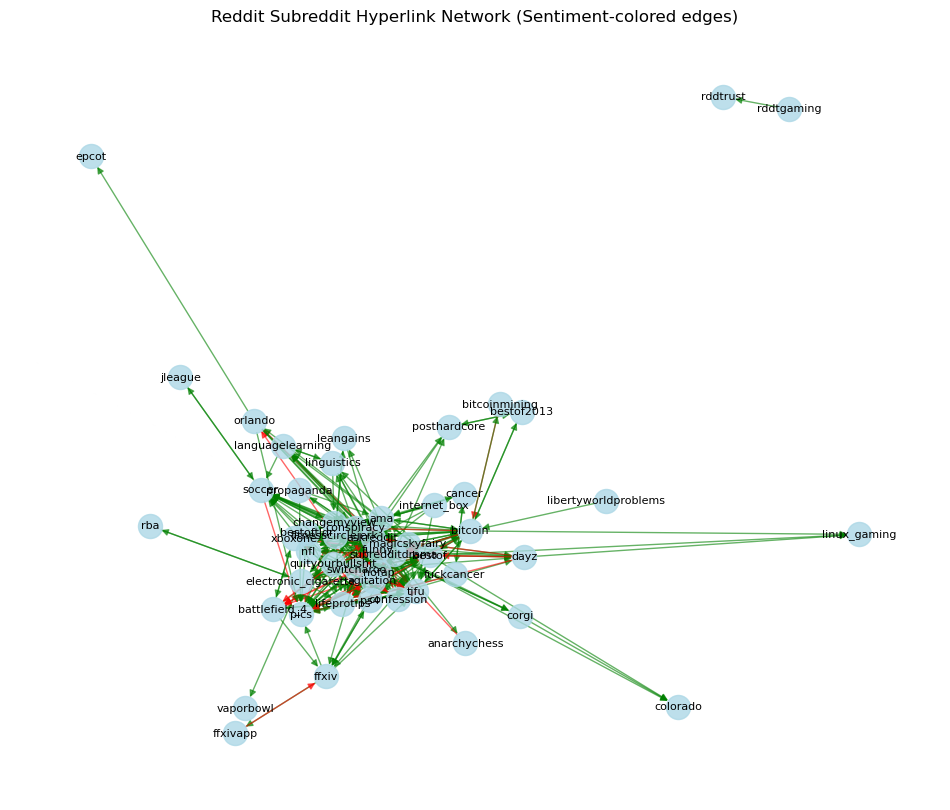

In [43]:

# Optional: take a subset of nodes
subgraph_nodes = list(G.nodes)[:50]  # first 50 subreddits
H = G.subgraph(subgraph_nodes)

# Color edges by sentiment
edge_colors = ['green' if G[u][v]['sentiment'] == 1 else 'red' for u, v in H.edges()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, seed=42, k=0.3)

nx.draw_networkx_nodes(H, pos, node_size=300, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, arrows=True, alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=8)

plt.title("Reddit Subreddit Hyperlink Network (Sentiment-colored edges)")
plt.axis("off")
plt.show()


#### Clustering with KMeans 

The goal is to cluster the subreddits by their graph-based features similarities (i.e. degree, pagerank...)

These capture the position of a subreddit within the social graph.

For example:

High betweenness → acts as a bridge between communities

High pagerank → highly influential node

Low clustering → more isolated or fringe

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def extract_graph_features(G):
    """
    Compute graph-based structural features for each node (subreddit).

    Parameters
    ----------
    G : networkx.Graph or networkx.DiGraph
        The graph representing subreddit interactions (edges may carry sentiment).
        
    Returns
    -------
    features : pandas.DataFrame
        A DataFrame containing one row per node and columns:
        ['subreddit', 'degree', 'in_degree', 'out_degree',
         'clustering', 'pagerank', 'betweenness', 'closeness']
    """


    # Precompute metrics only once
    pagerank_dict = nx.pagerank(G)
    clustering_dict = nx.clustering(G.to_undirected())
    betweenness_centrality_dict = nx.betweenness_centrality(G)
    closeness_centrality_dict = nx.closeness_centrality(G)

    # Build features efficiently
    features = pd.DataFrame({
        'subreddit': list(G.nodes()),
        'degree': [G.degree(n) for n in G.nodes()],
        'in_degree': [G.in_degree(n) for n in G.nodes()],
        'out_degree': [G.out_degree(n) for n in G.nodes()],
        'clustering': [clustering_dict[n] for n in G.nodes()],
        'pagerank': [pagerank_dict[n] for n in G.nodes()],
        'betweenness': [betweenness_centrality_dict[n] for n in G.nodes()],
        'closeness': [closeness_centrality_dict[n] for n in G.nodes()],
    })

    return features

features = extract_graph_features(G_core)
n_clusters = 20

def kmeans_cluster_graph_features(features, n_clusters=10):
    """
    Perform KMeans clustering on extracted graph features and add cluster labels.

    Parameters
    ----------
    features : pandas.DataFrame
        The node-level features computed by `extract_graph_features`.
    n_clusters : int, optional
        Number of clusters for KMeans (default is 10).

    Returns
    -------
    features_with_clusters : pandas.DataFrame
        Same as input, but with an extra column: 'cluster'.
    kmeans : sklearn.cluster.KMeans
        The trained KMeans model (for later analysis or visualization).
    """


    # Normalize features
    X = features[['degree', 'in_degree', 'out_degree', 'clustering', 'pagerank', 'betweenness','closeness']]
    X_scaled = StandardScaler().fit_transform(X)

    # Cluster subreddits
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    features['cluster'] = kmeans.fit_predict(X_scaled)

    return features, kmeans

features, kmeans_model = kmeans_cluster_graph_features(features, n_clusters)

# --- Mean sentiment per subreddit ---
# Each subreddit may appear as SOURCE or TARGET, so we consider both
## mean_sentiment = df_filtered.groupby('SOURCE_SUBREDDIT')['LINK_SENTIMENT'].mean()
def mean_sentiment_per_subreddit_in_graph(G, df, features):
    """
    Compute the mean sentiment of each subreddit in the graph G and the variance of these 
    mean sentiment scores within each cluster.
    Add 'mean_sentiment' and 'sentiment_variance' columns to the features.

    Parameters
    ----------
    G : networkx.Graph or networkx.DiGraph
        The subreddit interaction graph. Only subreddits (nodes) present 
        in this graph are considered when computing sentiment averages.

    df : pandas.DataFrame
        The full dataset of subreddit interactions.

    features : pandas.DataFrame
        A DataFrame containing per-subreddit graph features and cluster 
        assignments. 

    Returns
    -------
    features : pandas.DataFrame
        The input `features` DataFrame enriched with new 'mean_sentiment' and 'sentiment_variance'
        columns.
    cluster_variance : pandas.DataFrame
        A separate DataFrame summarizing the variance of mean sentiment per cluster.
    """

    valid_subreddits = set(G.nodes())

    mean_sentiment = (
        df[df['SOURCE_SUBREDDIT'].isin(valid_subreddits)]
        .groupby('SOURCE_SUBREDDIT')['LINK_SENTIMENT']
        .mean()
    )


    # Convert to DataFrame and merge
    sentiment_df = mean_sentiment.reset_index()
    sentiment_df.columns = ['subreddit', 'mean_sentiment']

    # Merge into features
    features = features.merge(sentiment_df, on='subreddit', how='left')

    # --- Variance of sentiment within each cluster ---
    cluster_variance = features.groupby('cluster')['mean_sentiment'].var().reset_index()
    cluster_variance.columns = ['cluster', 'sentiment_variance']

    ### ###
    print("Variance of mean sentiment within each cluster:")
    print(cluster_variance)

    # Add cluster variance to features if useful
    features = features.merge(cluster_variance, on='cluster', how='left')

    return features, cluster_variance

features, cluster_variance = mean_sentiment_per_subreddit_in_graph(G_core, df, features)
# Inspect enriched feature table
features.head()



Variance of mean sentiment within each cluster:
    cluster  sentiment_variance
0         0            0.027461
1         1            0.001626
2         2            0.052206
3         3            0.008211
4         4            0.030483
5         5            0.012361
6         6            0.088796
7         7            0.030013
8         8            0.013031
9         9            0.016008
10       10            0.015990
11       11            0.015464
12       12            0.023043
13       13            0.007978
14       14            0.009309
15       15            0.032812
16       16            0.041015
17       17            0.015559
18       18            0.000588
19       19            0.025139


,subreddit,degree,in_degree,out_degree,clustering,pagerank,betweenness,closeness,cluster,mean_sentiment,sentiment_variance
0,food,97,74,23,0.702198,0.003063,0.000826,0.614198,10,0.967213,0.015990
1,askhistorians,167,92,75,0.617125,0.008533,0.005760,0.650327,12,0.773890,0.023043
2,subredditdrama,305,111,194,0.525743,0.004310,0.035304,0.693380,2,0.349616,0.052206
3,electronic_cigarette,91,35,56,0.718246,0.001563,0.000931,0.545205,15,0.945687,0.032812
4,nottheonion,147,104,43,0.636415,0.003648,0.003128,0.674576,7,0.916168,0.030013


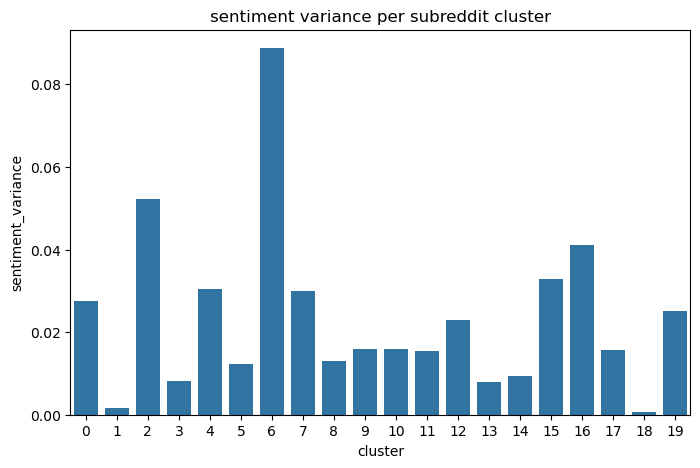

In [126]:
cluster_variance.head
plt.figure(figsize=(8,5))
sns.barplot(data=cluster_variance, x='cluster', y='sentiment_variance')
plt.title('sentiment variance per subreddit cluster')
plt.show()

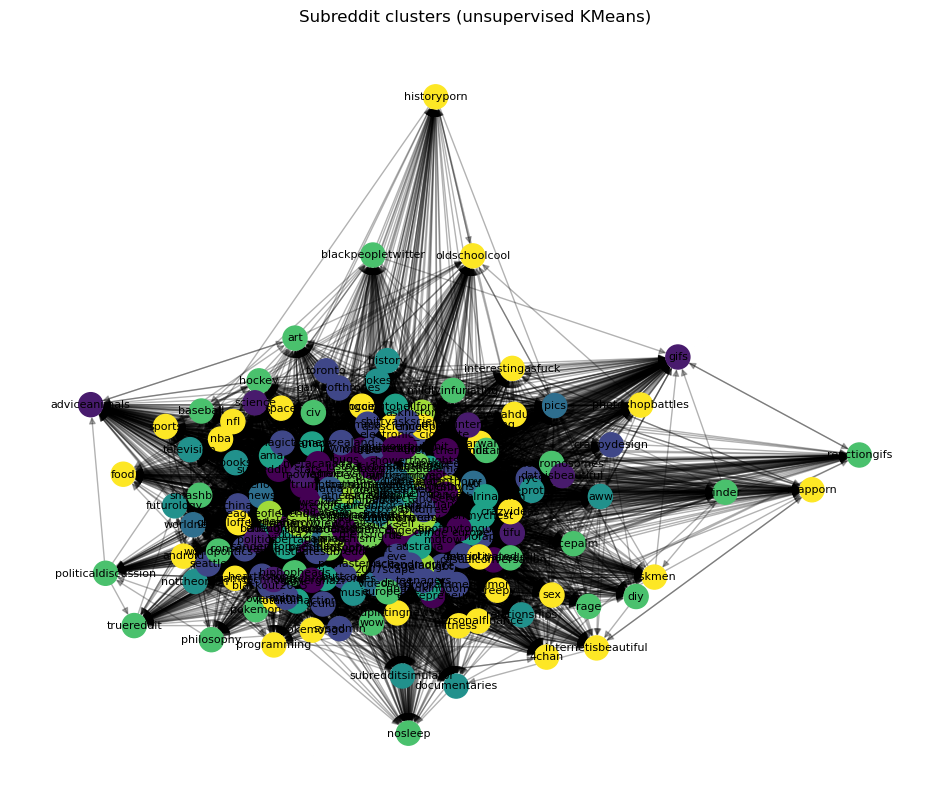

In [113]:
def visualize_clusters(G, features) :
    ## Visualize clusters with KMeans

    pos = nx.spring_layout(G, seed=42, k=0.3)
    node_colors = [features.set_index('subreddit').loc[n, 'cluster'] for n in G.nodes()]

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors, cmap='viridis')
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Subreddit clusters (unsupervised KMeans)")
    plt.axis("off")
    plt.show()


visualize_clusters(G_core, features)


In [114]:
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(features[features['cluster'] == i]['subreddit'].head(10).tolist())


Cluster 0:
['anarchism', 'entrepreneur', 'de', 'subreddit_stats', 'bugs', 'badeconomics', 'christianity', 'conspiratard', 'murica', 'vegan']

Cluster 1:
['tifu', 'movies', 'mildlyinteresting', 'dataisbeautiful', 'adviceanimals', 'science', 'gifs', 'politics', 'technology']

Cluster 2:
['subredditdrama', 'bestof']

Cluster 3:
['electronic_cigarette', 'drugs', 'lgbt', 'conservative', 'unexpected', 'seattle', 'buttcoin', 'nofap', 'china', 'protectandserve']

Cluster 4:
['askreddit', 'iama']

Cluster 5:
['pics', 'videos', 'showerthoughts', 'news', 'gaming', 'explainlikeimfive', 'worldnews', 'wtf']

Cluster 6:
['titlegore', 'copypasta', 'shitredditsays', 'theydidthemath', 'drama']

Cluster 7:
['nottheonion', 'documentaries', 'relationships', 'history', 'futurology', 'subredditsimulator', 'jokes', 'music', 'television', 'aww']

Cluster 8:
['imgoingtohellforthis', 'undelete', 'canada', 'ama', 'offmychest', 'dota2', 'unitedkingdom', 'cringe', 'casualiama', 'twoxchromosomes']

Cluster 9:
['the

/Users/maguettediouf/Documents/TheOtherTagADA/ada-2025-project-othertagada/src/utils/plot_utils.py:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=features, x='cluster', y='mean_sentiment', ci='sd', palette='viridis')
/Users/maguettediouf/Documents/TheOtherTagADA/ada-2025-project-othertagada/src/utils/plot_utils.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features, x='cluster', y='mean_sentiment', ci='sd', palette='viridis')


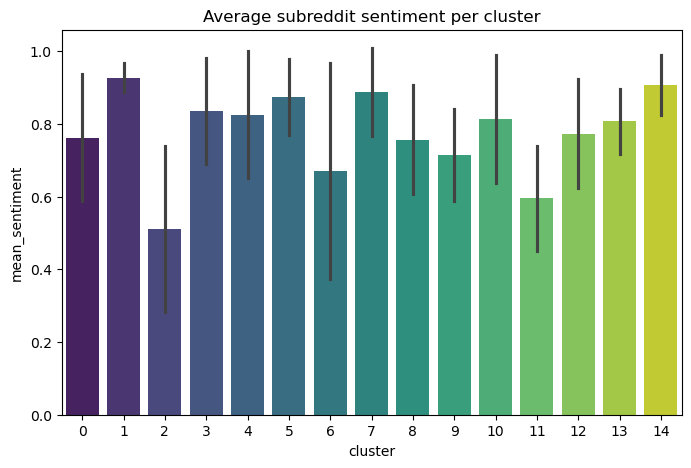

In [115]:
# Visualize average sentiment per cluster with standard deviation

plot_average_sentiment_per_cluster(features)


Some clusters have subreddits with similar sentiment mean but some other have spread value.